## Example Usage for the ndx-patterne-ogen-stimulation for 2D stimulus 
In the following tutorial, we demonstrate use of the `ndx-patterned-ogen` extension to the NWB data standard. Specifically we:
1. Create `SpatialLightModulator2D` and `LightSource` containers, representing the devices used in the paradigm.
2. Use the `PatternedOptogeneticStimulusSite` container to store information about location, the opsin and excitation wavelength used in the paradigm
3. Use the `OptogeneticStimulus2DPattern` (or `SpiralScanning` or `TemporalFocusing`) container to store the pattern-specific parameters of the stimulus onset.
4. Record the stimulus presentation within the `PatternedOptogeneticStimulusTable` container
6. Write all devices, stimuli, and presentation tables to an `.nwb` file and confirm it can be read back

First, we import then necessary files and create an empty `NWBFile`.

In [1]:
import datetime
import numpy as np
from pynwb import NWBFile, NWBHDF5IO
from ndx_patterned_ogen import (
    SpatialLightModulator2D,
    LightSource,
    PatternedOptogeneticStimulusSite,
    PatternedOptogeneticStimulusTable,
    OptogeneticStimulus2DPattern,
    OptogeneticStimulusTarget,
    SpiralScanning,
    TemporalFocusing,
)
from hdmf.common.table import DynamicTableRegion

from pynwb.ophys import PlaneSegmentation, ImageSegmentation, OpticalChannel

nwbfile = NWBFile(
    session_description="patterned optogenetic synthetic experiment (all optical system)",
    identifier="identifier",
    session_start_time=datetime.datetime.now(datetime.timezone.utc),
)

## Spatial light modulator and Light source

We begin by creating all the devices needed in this stimulation paradigm: `SpatialLightModulator2D` , `LightSource` and a microscope 

In [2]:
# metadata for spiatial light modulator
spatial_light_modulator = SpatialLightModulator2D(
    name="SpatialLightModulator2D",
    description="Generic description for the slm",
    manufacturer="slm manufacturer",
    spatial_resolution_in_px=[512, 512],
)
nwbfile.add_device(spatial_light_modulator)

# metadata for the light source
light_source = LightSource(
    name="Laser",
    model="laser model",
    manufacturer="laser manufacturer",
    stimulation_wavelength_in_nm=1035.0,  # nm
    filter_description="Short pass at 1040 nm",
    description="Generic description for the laser",
    peak_power_in_W=70e-3,  # the peak power of stimulation in Watts
    intensity_in_W_per_m2=0.005,  # the intensity of excitation in W/mm^2
    exposure_time_in_s=2.51e-13,  # the exposure time of the sample in seconds
    pulse_rate_in_Hz=1 / 2.51e-13,  # the pulse rate of the laser is in Hz
)
nwbfile.add_device(light_source)

# metadata for the microscope
microscope = nwbfile.create_device(
    name="2P_microscope",
    description="My two-photon microscope",
    manufacturer="The best microscope manufacturer",
)

# Optogenetic stimulus site

Store the information about the location, the opsin and excitation wavelength used in the paradigm 

In [3]:
# metadata for the stimulus methods
site = PatternedOptogeneticStimulusSite(
    name="PatternedOptogeneticStimulusSite",
    description="Scanning",  # Scanning or scanless method for shaping optogenetic light (e.g., diffraction limited points, 3D shot, disks, etc.).
    excitation_lambda=600.0,  # nm
    effector="ChR2",
    location="VISrl",
    device=microscope,
    spatial_light_modulator=spatial_light_modulator,
    light_source=light_source,
)
nwbfile.add_ogen_site(site)

PatternedOptogeneticStimulusSite ndx_patterned_ogen.patterned_ogen.PatternedOptogeneticStimulusSite at 0x140319671366000
Fields:
  description: Scanning
  device: 2P_microscope pynwb.device.Device at 0x140321045509376
Fields:
  description: My two-photon microscope
  manufacturer: The best microscope manufacturer

  effector: ChR2
  excitation_lambda: 600.0
  light_source: Laser abc.LightSource at 0x140319685390176
Fields:
  description: Generic description for the laser
  exposure_time_in_s: 2.51e-13
  filter_description: Short pass at 1040 nm
  intensity_in_W_per_m2: 0.005
  manufacturer: laser manufacturer
  model: laser model
  peak_power_in_W: 0.07
  pulse_rate_in_Hz: 3984063745019.9204
  stimulation_wavelength_in_nm: 1035.0

  location: VISrl
  spatial_light_modulator: SpatialLightModulator2D abc.SpatialLightModulator2D at 0x140321045509664
Fields:
  description: Generic description for the slm
  manufacturer: slm manufacturer
  spatial_resolution_in_px: [512 512]

## Define the stimulus pattern applied during the photostimulation

For demonstrative purpose, we define here fout different stimulation pattern: 
1. two generic where the `sweep_size` and the `sweep_mask` can be defined to describe the spatial pattern. If `sweep_size` is a scalar, the sweep pattern is assumed to be a circle with diameter `sweep_size`. If `sweep_size` is a two or three dimensional array, the the sweep pattern is assumed to be a rectangle, with dimensions [width, height]. If the shape is neither a circle or a rectangular, the shape can be save in `sweep_mask`. 
2. one spiral pattern
3. one temporal focusing beam pattern

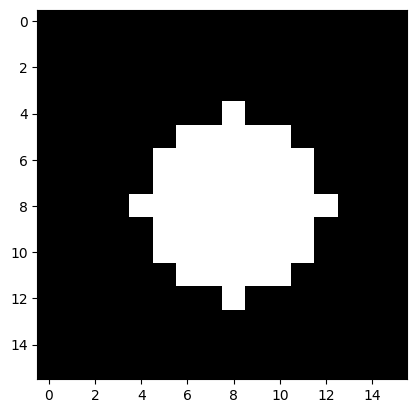

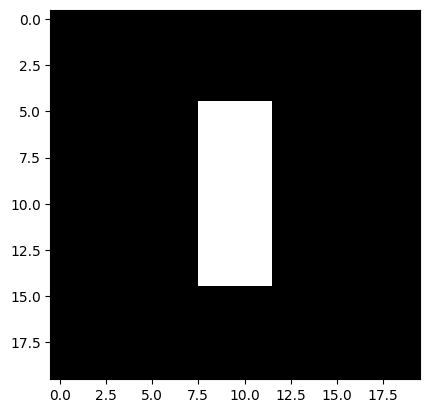

TemporalFocusing abc.TemporalFocusing at 0x140319659264384
Fields:
  axial_point_spread_function_in_um: 32 um ± 1.6 um
  description: scanless beam pattern
  lateral_point_spread_function_in_um: 9 um ± 0.7 um

In [4]:
# metadata for a generic stimulus pattern
import numpy as np
import matplotlib.pyplot as plt

# auxiliary function to generate the sweep shape, either circular or rectangular
# TODO ADD THE  generate_image_mask_np function as a method of all the pattern class
def generate_image_mask_np(width, height, sweep_size_in_pizels):
    # Create a black image mask
    image_mask = np.zeros((height, width), dtype=np.uint8)

    # Calculate the position for the center of the white spot
    center_x = width // 2
    center_y = height // 2

    if isinstance(sweep_size_in_pizels, int):
        # Circular spot
        Y, X = np.ogrid[:height, :width]
        dist_from_center = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)
        image_mask[dist_from_center <= sweep_size_in_pizels / 2]=255

    elif len(sweep_size_in_pizels) == 2:
        # Rectangular spot
        half_width = sweep_size_in_pizels[0] // 2
        half_height = sweep_size_in_pizels[1] // 2
        top_left = (center_x - half_width, center_y - half_height)
        bottom_right = (center_x + half_width, center_y + half_height)
        image_mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 255
    else:
        raise ValueError("Invalid sweep_size_in_pizels. Should be a scalar or a 2-element array.")
    return image_mask

sweep_size=[8] 
circular_image_mask_np = generate_image_mask_np(width=sweep_size[0]*2, height=sweep_size[0]*2, sweep_size_in_pizels=sweep_size[0]) # assuming 1 pixel=1 um
generic_circular_pattern = OptogeneticStimulus2DPattern(
    name="CircularOptogeneticStimulusPattern",
    description="circular pattern",
    sweep_size_in_um=sweep_size,  # um
    # sweep_mask=circular_image_mask_np,
)
nwbfile.add_lab_meta_data(generic_circular_pattern)

# Display the image mask using matplotlib
plt.imshow(circular_image_mask_np, cmap='gray')
plt.show()

sweep_size=[5,10]
rectangular_image_mask_np = generate_image_mask_np(width=20, height=20, sweep_size_in_pizels=sweep_size)
generic_rectangular_pattern = OptogeneticStimulus2DPattern(
    name="RectangularOptogeneticStimulusPattern",
    description="rectangular pattern",
    sweep_size_in_um=sweep_size,  # um
    sweep_mask=rectangular_image_mask_np,
)
nwbfile.add_lab_meta_data(generic_rectangular_pattern)

# Display the image mask using matplotlib
plt.imshow(rectangular_image_mask_np, cmap='gray')
plt.show()

# metadata for spiral scanning pattern
spiral_scanning = SpiralScanning(
    name="SpiralScanning",
    diameter_in_um=15,  # um
    height_in_um=10,  # um
    number_of_revolutions=5,
    description="scanning beam pattern",
)
nwbfile.add_lab_meta_data(spiral_scanning)

# metadata for temporal focusing pattern
temporal_focusing = TemporalFocusing(
    name="TemporalFocusing",
    description="scanless beam pattern",
    lateral_point_spread_function_in_um="9 um ± 0.7 um",
    axial_point_spread_function_in_um="32 um ± 1.6 um",
)
nwbfile.add_lab_meta_data(temporal_focusing)

## Plane segmentation containing information of stimulated ROIs 
Define two `PlaneSegmentation` tables; one for post-hoc ROI (possibly cell) identification; the other for targeted ROIs. Additional columns on both tables can indicate if the ROI is a cell, and the two tables can be harmonized with the use of a global_roi_id field that matches ROI IDs from one table to the other.

To do so, we need to define an `ImagingPlane` and an `OpticalChannel` first.

In [5]:
optical_channel = OpticalChannel(
    name="OpticalChannel",
    description="an optical channel",
    emission_lambda=500.0,
)
imaging_plane = nwbfile.create_imaging_plane(
    name="ImagingPlane",
    optical_channel=optical_channel,
    imaging_rate=30.0,
    description="a very interesting part of the brain",
    device=microscope,
    excitation_lambda=600.0,
    indicator="GFP",
    location="V1",
    grid_spacing=[0.01, 0.01],
    grid_spacing_unit="meters",
    origin_coords=[1.0, 2.0, 3.0],
    origin_coords_unit="meters",
)

All the ROIs simulataneously illuminated are stored in `targeted_rois` in an `OptogeneticStimulusTarget` container, as a table region referencing the `TargetPlaneSegmentation`.
In this example, the targeted ROIs are 45 in total, divided in 3 groups of 15 ROIs that will be simulataneously illuminated with the same stimulus pattern. Only 30 of them, 10 for each group, results in a successful photostimulation.
Therefore, we define a `PlaneSegmentation` containing 30 ROIs in total and 3 `roi_table_region` containing 10 ROIs each that would be segmented after being stimulated, and stored in three separate `OptogeneticStimulusTarget` containers.

In [6]:
n_targeted_rois = 45
n_targeted_rois_per_group = n_targeted_rois // 3

targeted_rois_centroids = np.array([[i, i, 0] for i in np.arange(n_targeted_rois, dtype=int)]) 

targeted_plane_segmentation = PlaneSegmentation(
    name="TargetPlaneSegmentation",
    description="Table for storing the targeted roi centroids, defined by a one-pixel mask",
    imaging_plane=imaging_plane,
)

for roi_centroid in targeted_rois_centroids:
    targeted_plane_segmentation.add_roi(pixel_mask=[roi_centroid])

if nwbfile is not None:
    if "ophys" not in nwbfile.processing:
        nwbfile.create_processing_module("ophys", "ophys")
    nwbfile.processing["ophys"].add(targeted_plane_segmentation)

targeted_rois_1 = targeted_plane_segmentation.create_roi_table_region(
    name="targeted_rois",  # it must be called "segmented_rois"
    description="targeted rois",
    region=list(np.arange(n_targeted_rois_per_group, dtype=int)),
)

targeted_rois_2 = targeted_plane_segmentation.create_roi_table_region(
    name="targeted_rois",  # it must be called "segmented_rois"
    description="targeted rois",
    region=list(np.arange(n_targeted_rois_per_group,2*n_targeted_rois_per_group, dtype=int)),
)

targeted_rois_3 = targeted_plane_segmentation.create_roi_table_region(
    name="targeted_rois",  # it must be called "segmented_rois"
    description="targeted rois",
    region=list(np.arange(2*n_targeted_rois_per_group,n_targeted_rois, dtype=int)),
)


In [7]:

n_segmented_rois = 30
n_segmented_rois_per_group = n_segmented_rois // 3


plane_segmentation = PlaneSegmentation(
    name="PlaneSegmentation",
    description="output from segmenting my favorite imaging plane",
    imaging_plane=imaging_plane,
)

#TODO add global_roi_id

for _ in range(n_segmented_rois):
    plane_segmentation.add_roi(image_mask=np.zeros((512, 512)))

if nwbfile is not None:
    if "ophys" not in nwbfile.processing:
        nwbfile.create_processing_module("ophys", "ophys")
    nwbfile.processing["ophys"].add(plane_segmentation)


segmented_rois_1 = plane_segmentation.create_roi_table_region(
    name="segmented_rois",  # it must be called "segmented_rois"
    description="segmented rois",
    region=list(np.arange(n_segmented_rois_per_group, dtype=int)),
)

segmented_rois_2 = plane_segmentation.create_roi_table_region(
    name="segmented_rois",
    description="segmented rois",
    region=list(np.arange(n_segmented_rois_per_group, 2 * n_segmented_rois_per_group, dtype=int)),
)

segmented_rois_3 = plane_segmentation.create_roi_table_region(
    name="segmented_rois",
    description="segmented rois",
    region=list(np.arange(2 * n_segmented_rois_per_group, n_segmented_rois, dtype=int)),
)


In [8]:
hologram_1 = OptogeneticStimulusTarget(
    name="Hologram1", segmented_rois=segmented_rois_1, targeted_rois=targeted_rois_1
)
nwbfile.add_lab_meta_data(hologram_1)

hologram_2 = OptogeneticStimulusTarget(
    name="Hologram2", segmented_rois=segmented_rois_2, targeted_rois=targeted_rois_2
)

nwbfile.add_lab_meta_data(hologram_2)

hologram_3 = OptogeneticStimulusTarget(
    name="Hologram3", targeted_rois=targeted_rois_3
)

nwbfile.add_lab_meta_data(hologram_3)

,pixel_mask
id,
0,"[[0, 0, 0]]"
1,"[[1, 1, 0]]"
2,"[[2, 2, 0]]"
3,"[[3, 3, 0]]"


## Define photostimulation table 

Define the stimulus sequences on the targeted ROIs previously defined in the imaging frame coordinates 
If `power`,`frequency` and `pulse_width` are defined as a scalar it is assumed that all the ROIs defined in `targets` receive the same stimulus `power`,`frequency` and `pulse_width`. However, we can also define `power`,`frequency` and `pulse_width` as 1D arrays of dimension equal to the number of ROIs in targets, so we can define different `power`,`frequency` and `pulse_width` for each target.

In [9]:
stimulus_table = PatternedOptogeneticStimulusTable(
    name="PatternedOptogeneticStimulusTable", description="Patterned stimulus"
)
stimulus_table.add_interval(
    start_time=0.0,
    stop_time=1.0,
    power=70e-3,
    frequency=20.0,
    pulse_width=0.01,
    stimulus_pattern=temporal_focusing,
    targets=nwbfile.lab_meta_data["Hologram1"],
    stimulus_site=site,
)
stimulus_table.add_interval(
    start_time=0.5,
    stop_time=1.0,
    power=50e-3,
    frequency=20.0,
    pulse_width=0.01,
    stimulus_pattern=spiral_scanning,
    targets=hologram_2,
    stimulus_site=site,
)
stimulus_table.add_interval(
    start_time=0.8,
    stop_time=1.7,
    power=40e-3,
    frequency=20.0,
    pulse_width=0.01,
    stimulus_pattern=generic_circular_pattern,
    targets=hologram_3,
    stimulus_site=site,
)

nwbfile.add_time_intervals(stimulus_table)

,start_time,stop_time,power,frequency,pulse_width,targets,stimulus_pattern,stimulus_site
id,,,,,,,,
0,0.0,1.0,0.07,20.0,0.1,Hologram1 ndx_patterned_ogen.patterned_ogen.OptogeneticStimulusTarget at 0x140319653226032\nFields:\n segmented_rois: segmented_rois <class 'hdmf.common.table.DynamicTableRegion'>\n targeted_rois: targeted_rois <class 'hdmf.common.table.DynamicTableRegion'>\n,TemporalFocusing abc.TemporalFocusing at 0x140319659264384\nFields:\n axial_point_spread_function_in_um: 32 um ± 1.6 um\n description: scanless beam pattern\n lateral_point_spread_function_in_um: 9 um ± 0.7 um\n,PatternedOptogeneticStimulusSite ndx_patterned_ogen.patterned_ogen.PatternedOptogeneticStimulusSite at 0x140319671366000\nFields:\n description: Scanning\n device: 2P_microscope pynwb.device.Device at 0x140321045509376\nFields:\n description: My two-photon microscope\n manufacturer: The best microscope manufacturer\n\n effector: ChR2\n excitation_lambda: 600.0\n light_source: Laser abc.LightSource at 0x140319685390176\nFields:\n description: Generic description for the laser\n exposure_time_in_s: 2.51e-13\n filter_description: Short pass at 1040 nm\n intensity_in_W_per_m2: 0.005\n manufacturer: laser manufacturer\n model: laser model\n peak_power_in_W: 0.07\n pulse_rate_in_Hz: 3984063745019.9204\n stimulation_wavelength_in_nm: 1035.0\n\n location: VISrl\n spatial_light_modulator: SpatialLightModulator2D abc.SpatialLightModulator2D at 0x140321045509664\nFields:\n description: Generic description for the slm\n manufacturer: slm manufacturer\n spatial_resolution_in_px: [512 512]\n\n
1,0.5,1.0,0.05,20.0,0.1,Hologram2 ndx_patterned_ogen.patterned_ogen.OptogeneticStimulusTarget at 0x140321045763456\nFields:\n segmented_rois: segmented_rois <class 'hdmf.common.table.DynamicTableRegion'>\n targeted_rois: targeted_rois <class 'hdmf.common.table.DynamicTableRegion'>\n,SpiralScanning abc.SpiralScanning at 0x140319654796544\nFields:\n description: scanning beam pattern\n diameter_in_um: 15\n height_in_um: 10\n number_of_revolutions: 5\n,PatternedOptogeneticStimulusSite ndx_patterned_ogen.patterned_ogen.PatternedOptogeneticStimulusSite at 0x140319671366000\nFields:\n description: Scanning\n device: 2P_microscope pynwb.device.Device at 0x140321045509376\nFields:\n description: My two-photon microscope\n manufacturer: The best microscope manufacturer\n\n effector: ChR2\n excitation_lambda: 600.0\n light_source: Laser abc.LightSource at 0x140319685390176\nFields:\n description: Generic description for the laser\n exposure_time_in_s: 2.51e-13\n filter_description: Short pass at 1040 nm\n intensity_in_W_per_m2: 0.005\n manufacturer: laser manufacturer\n model: laser model\n peak_power_in_W: 0.07\n pulse_rate_in_Hz: 3984063745019.9204\n stimulation_wavelength_in_nm: 1035.0\n\n location: VISrl\n spatial_light_modulator: SpatialLightModulator2D abc.SpatialLightModulator2D at 0x140321045509664\nFields:\n description: Generic description for the slm\n manufacturer: slm manufacturer\n spatial_resolution_in_px: [512 512]\n\n
2,0.8,1.7,0.04,20.0,0.1,Hologram3 ndx_patterned_ogen.patterned_ogen.OptogeneticStimulusTarget at 0x140321045763696\nFields:\n targeted_rois: targeted_rois <class 'hdmf.common.table.DynamicTableRegion'>\n,CircularOptogeneticStimulusPattern abc.OptogeneticStimulus2DPattern at 0x140319671364608\nFields:\n description: circular pattern\n sweep_size_in_um: [8]\n,PatternedOptogeneticStimulusSite ndx_patterned_ogen.patterned_ogen.PatternedOptogeneticStimulusSite at 0x140319671366000\nFields:\n description: Scanning\n device: 2P_microscope pynwb.device.Device at 0x140321045509376\nFields:\n description: My two-photon microscope\n manufacturer: The best microscope manufacturer\n\n effector: ChR2\n excitation_lambda: 600.0\n light_source: Laser abc.LightSource at 0x140319685390176\nFields:\n description: Generic description for the laser\n exposure_time_in_s: 2.51e-13\n filter_description: Short pass at 1040 nm\n intensity_in_W_per_m2: 0.005\n manufacturer

Write and read the NWB File

In [10]:
nwbfile_path = "basics_tutorial_patterned_ogen.nwb"
with NWBHDF5IO(nwbfile_path, mode="w") as io:
    io.write(nwbfile)

with NWBHDF5IO(nwbfile_path, mode="r") as io:
    nwbfile_in = io.read()